# Using Naive Bayes for Multiclass Labeling of Job Data

## LogReg vs MNB vs CNB

Understanding the availability of jobs is important in determining which positions to feature in ads, who to target, where to target them, and which platforms to target them on.

As discussed in the Job Listing EDA notebook, labeling jobs by role or company can be error prone. Instead, learning patterns which are common in a certain type of job and applying a label automatically may be helpful. Especially when dealing with over 10M jobs each day. 

Here, we continue to explore NLP approaches to classify jobs by title. Previously, we only considered whether a job is a skilled position (nurses, engineers, consultants) or a gig-role (drivers, cashiers, shoppers). Now, we turn our attention to labeling roles into specific categories, such as "nurse", "driver", "service", "other"

As we continue to grow, we are more interested in targeting job seekers beyond the gig market. Specifically, certain markets have shown higher conversions for skilled positions, such as nursing. Thus, it is important to have a model that can provide our ad-ops teams with a variety of roles.

## Naive Bayes

Naive Bayes classifiers are a group of probabilistic methods that apply Bayes' theorem while assuming (naively) conditional independence between every pair of features given the value of the class variable. 

Previously, we explored Naive Bayes classifiers as they offer several distinct benefits:

+ Easy to understand: a term has a probability of being associated with a particular label 
+ Easy to train and can be used to apply multiple labels, given sufficient training examples for each label 
+ Model can continue to be re-trained as more labeled samples become available

In [2]:
import os, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# update & anonymize data source
data = pd.read_csv('../data/multiclass/gigs_relabeled.csv')
data = data.dropna()
data.columns

Index(['title', 'company', 'city', 'state', 'url', 'gig', 'label'], dtype='object')

In [17]:
# drop unnecessary / underrepresented labels for demo
data = data[~(data['label']=='security')]
data.label.value_counts()

ignore     123
driver     120
retail      45
service     31
Name: label, dtype: int64

** Cleanup text **

In [5]:
def standardize_text(df, text_field):
    '''Clean-up text column to prepare for tokenization
    
    Removes unwanted characters &
    Replaces them with spaces or blanks
    --
    Input
    + pandas dataframe
    + name of text column
    
    Returns
    + pandas dataframe with cleaned column
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [19]:
cols_to_train = ['title', 'label'] 
data = data[cols_to_train]    

data = standardize_text(data, 'title')

col_names = {'title':'job_title',
             'label':'class_label'}    

data = data.rename(columns=col_names)

data.head()

,job_title,class_label
0,driver,driver
1,route sales driver owensboro ky,driver
2,what is the homes platform team at airbnb?,ignore
4,"be your own boss earn 1,700 your first mont...",driver
5,"be your own boss earn 900 your first month,...",driver


## Preprocessing

In [8]:
import keras
import nltk
import re
import codecs

In [9]:
from nltk.tokenize import RegexpTokenizer

### Evaluation & Vizualization tools

Some functions to help assess model performance.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def fit_vectorizer(data, vec_type='count'):
    '''Create and fit a vectorizer
    
    Options:
    + count -> count_vectorizer 
    + tfidf -> tfidf_vectorizer
    
    Input:
    + data - X data to fit the model
    + vec_type - name of vectorizer to use
    
    Returns:
    + Document-term matrix or Tf-idf-weighted document-term matrix
    + vectorizer - fitted model
    '''
    if vec_type=='count':
        vectorizer = CountVectorizer()
    elif vec_type=='tfidf':
        vectorizer = TfidfVectorizer()
    else:
        print('Please select an appropriate option')
    
    emb = vectorizer.fit_transform(data)

    return emb, vectorizer

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    '''
    
    Plot a confusion matrix to visualize classification performance
    
    Input:
    + cm - confusion matrix for a classifier
    + target_names - names of classes (use clf.classes_)
    + title - name of plot
    + cmap - option to specift colormap for plot
    + normalize - option to normalize values
    
    Returns:
    + Plot of shaded confusion matrix, including accuracy and missclassification
    
    '''

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

    return plt

In [22]:
tokenizer = RegexpTokenizer(r'\w+')

data['tokens'] = data['job_title'].apply(tokenizer.tokenize)
data.head()

,job_title,class_label,tokens
0,driver,driver,[driver]
1,route sales driver owensboro ky,driver,"[route, sales, driver, owensboro, ky]"
2,what is the homes platform team at airbnb?,ignore,"[what, is, the, homes, platform, team, at, air..."
4,"be your own boss earn 1,700 your first mont...",driver,"[be, your, own, boss, earn, 1, 700, your, firs..."
5,"be your own boss earn 900 your first month,...",driver,"[be, your, own, boss, earn, 900, your, first, ..."


### Multiclass naive bayes

Here, we use Multinomial Naive Bayes. MNB implements the naive Bayes algorithm for multinomially distributed data. This is useful when features are discrete and is commonly used in text classification.

For later use, we should also consider Complement Naive Bayes. CNB is not tested here, as it is not available on the local version of scikit (0.19.0) at the time of this demo.

Complement Naive Bayes is an adaptation of the Multinomial Naive Bayes algorithm. It has been shown to outperform MNB on text classification tasks. It is also well suited for imbalanced data sets. 

In [14]:
from sklearn.naive_bayes import MultinomialNB 

In [23]:
# X -> features, y -> label 
X = data['job_title']
y = data['class_label']

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

X_train_counts, count_vectorizer = fit_vectorizer(X_train, vec_type='count')
X_test_counts = count_vectorizer.transform(X_test)
  
# training a Naive Bayes classifier 
mnb = MultinomialNB().fit(X_train_counts, y_train) 
mnb_predictions = mnb.predict(X_test_counts) 
  
# accuracy on X_test 
accuracy = mnb.score(X_test_counts, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, mnb_predictions)

0.75


75% accuracy is not great...but we don't have much data to begin with. Let's get some more.

In [23]:
mnb.classes_

array(['driver', 'ignore', 'retail', 'service'], dtype='<U7')

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

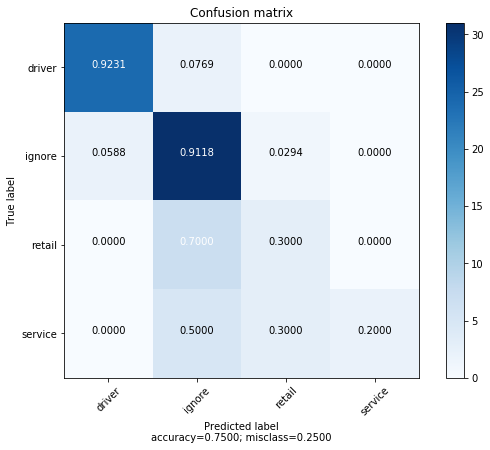

In [24]:
plot_confusion_matrix(cm, 
                      target_names=mnb.classes_,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

## Additional Training Data

### Training Set Size & Class imbalance

One noticeable issue is that in both of the previous datasets, we find ourselves with a small dataset to train our model. This isn't necessarily bad, as Naive Bayes can still perform fairly well, even with limited data. But when we want to apply our classifier to listings outside of a specific job feed, or to classify roles beyond the ones our model is trained to identify, we expect performance to suffer. Therefore, a larger labeled dataset is necessary to properly train our model for production.

Furthermore, we see a very large imbalance between the classes. The imbalance isn't the key issue here. Rather, we simply aren't seeing enough of the other classes to learn what they look like. We can return to a more primitive method of labeling roles if the name of the role is present in the title. This allows us to also pick up on secondary terms which may also be associated with a particular role. Most importantly, this allows us to grow the size of the training data, and add more observances of the underrepresented classes.

In [56]:
# load labeled data
df_labeled = pd.read_csv('../data/multiclass/labeled_large.csv')

# remove samples not of interest
exclude = ['crna', 'pharmacist', 'cna']
df_labeled = df_labeled[~(df_labeled.isin(exclude))]

# map roles to general labels
role_mapper = {'delivery':'driver', 
               'server':'service', 
               'product manager':'ignore', 
               'software engineer':'ignore',
               'electrical engineer':'ignore', 
               'systems engineer':'ignore', 
               'mechanical engineer':'ignore',
               'nurse':'nurse', 
               'business analyst':'ignore', 
               'cook':'service', 
               'chef':'service',
               'devops engineer':'ignore', 
               'machine learning engineer':'ignore', 
               'registered nurse':'nurse', 
               'cdl':'ignore'}

df_labeled['label'] = df_labeled['role'].map(role_mapper)

df_labeled = df_labeled[cols_to_train]

df_labeled.head()

,title,role
0,warehouse/ delivery driver,delivery
1,warehouse/delivery driver,delivery
2,wait staff/server,server
3,wait staff/server,server
4,wait staff/server,server


In [60]:
df_labeled.label.value_counts()

ignore     72376
nurse      53862
service    48280
driver     22997
Name: label, dtype: int64

There is still an imbalance in classes, but much more representation of each class we're interested in labeling.

In [62]:
df_labeled = standardize_text(df_labeled, 'title')
df_labeled = df_labeled.rename(columns=col_names)
df_labeled.head()

,job_title,class_label
0,warehouse delivery driver,driver
1,warehouse delivery driver,driver
2,wait staff server,service
3,wait staff server,service
4,wait staff server,service


In [76]:
df_labeled = df_labeled.dropna()
tokenizer = RegexpTokenizer(r'\w+')

df_labeled['tokens'] = df_labeled['job_title'].apply(tokenizer.tokenize)
    
# X -> features, y -> label 
X = df_labeled['job_title']
y = df_labeled['class_label']

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 40) 

X_train_counts, count_vectorizer = fit_vectorizer(X_train, vec_type='count')
X_test_counts = count_vectorizer.transform(X_test)

# training a Naive Bayes classifier 
mnb = MultinomialNB().fit(X_train_counts, y_train) 
mnb_predictions = mnb.predict(X_test_counts) 

# accuracy on X_test 
accuracy = mnb.score(X_test_counts, y_test) 
print(accuracy)

# creating a confusion matrix 
cm = confusion_matrix(y_test, mnb_predictions)

0.9936207699629397


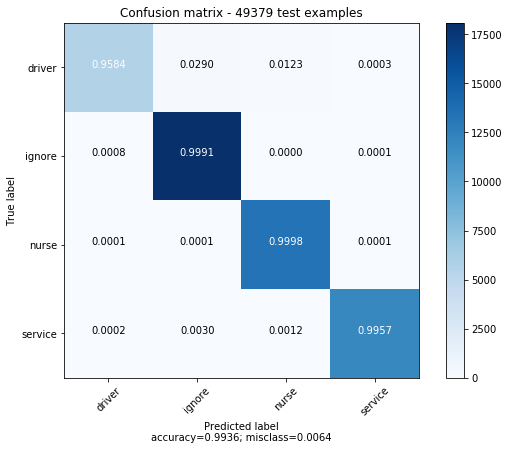

In [81]:
plot_confusion_matrix(cm, 
                          target_names=mnb.classes_,
                          title='Confusion matrix - {} test examples'.format(len(y_test)),
                          cmap=None,
                          normalize=True)

## Summary

We see that Naive Bayes identifies most roles with over 99.9% accuracy. In the cases where it is not so accurate, such driver roles, it is still above 95% accurate. For our purposes, this level of performance is acceptable, since a manual selection step is still involved after roles are labeled. Again, this approach greatly reduces manual processing time, and allows our team to sort through more jobs than possible without these methods.

Moving away from the two-class approach to labeling jobs allows for better and more rapid identification of roles within a specific area. For our purposes, this allows us to filter through 40 GB of job data daily and identify a select number of job posts to feature in online advertisements. This approach is extensible and can also be applied by potential job seekers to find roles they are interested in.

## Implementation

We found that in practice, Naive Bayes approaches, both Multinomial and Complement, performed inconsistently on out-of-test set data. Thus leading to unreliable job label predictions. Motivated by this, we tested Logistic Regression for multi-class labeling and found it very successful. Moreover, it was shown to perfom well on out of sample data and is currently used in production to generate daily job recommendations which feed into our chatbot.

Below are the results from evaluating a re-labeled training set to classify tech (software), nursing, service, and driving jobs, while ignoring the rest. We also evaluated complement naive Bayes in addition to logistic regression and multinomial NB. These sets were tested on AWS as the local machine where this notebook was created does not have the most current version of scikit-learn.

In [109]:
cm_labels = ['tech', 'nurse', 'service', 'driver', 'ignore']

lr_cm = np.array([[ 3580,     0,     0,     0,     3],
                  [    0, 13529,     2,     0,     0],
                  [    0,     0, 12160,     0,     3],
                  [    0,     0,     1,  5775,     3],
                  [   20,     0,     0,     1, 14302]])

mnb_cm = np.array([[ 3580,     0,     0,     0,     3],
                   [    1, 13529,     1,     0,     0],
                   [   45,    21, 12085,     5,     7],
                   [   11,    70,     0,  5550,   148],
                   [  547,     1,     0,    10, 13765]])

cnb_cm = np.array([[ 3579,     1,     0,     0,     3],
                   [    0, 13530,     1,     0,     0],
                   [    8,    18, 12130,     3,     4],
                   [   29,   132,    35,  5441,   142],
                   [   96,    10,     3,     3, 14211]])

In [117]:
# calculate precision, recall, f1 manually to confirm correct labels
def class_metrics(cm, class_labels):
    print('class | precision | recall | f1 score | jaccard')
    for i in range(len(class_labels)):
        tp = cm[i][i]
        fp = sum(cm[:,i]) - tp
        fn = sum(cm[i,:]) - tp
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        f = 2*(prec*rec)/(prec+rec)
        jaccard = tp/(tp+fp+fn)
        print(class_labels[i],tp, str(prec)[0:6], str(rec)[0:6], str(f)[0:6], str(jaccard)[0:6])
        
def class_metrics_df(cm, class_labels):
    
    # define & initialize
    metric_names = ['precision', 'recall', 'f1 score','jaccard']
    precs = []
    recs = []
    fs = []
    jacs = []
    
    for i in range(len(class_labels)):
        
        # calculate
        tp = cm[i][i]
        fp = sum(cm[:,i]) - tp
        fn = sum(cm[i,:]) - tp
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        f = 2*(prec*rec)/(prec+rec)
        jaccard = tp/(tp+fp+fn)
        
        # append
        precs.append(prec)
        recs.append(rec)
        fs.append(f)
        jacs.append(jaccard)
    
    # create df
    all_metrics = [precs, recs, fs, jacs]
    df = pd.DataFrame(all_metrics, 
             columns = class_labels, 
             index=metric_names).round(4).T
    
    return df

In [7]:
print('There are {} examples in the training set'.format(sum(sum(lr_cm))))

There are 49379 examples in the training set


<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

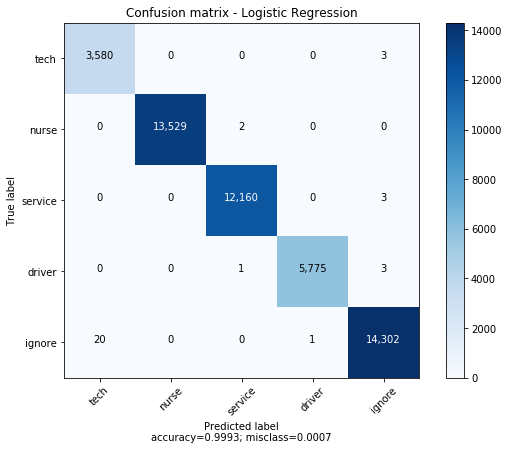

In [9]:
plot_confusion_matrix(lr_cm, target_names=cm_labels, title='Confusion matrix - Logistic Regression',
                      cmap=None, normalize=False)

In [121]:
print('LOGISTIC REGRESSION')

print('\nOverall metrics')
print('accuracy = 0.999, precision = 0.999, recall = 0.999, f1 = 0.999')

print('\nIn class metrics')
class_metrics_df(lr_cm, cm_labels)

LOGISTIC REGRESSION

Overall metrics
accuracy = 0.999, precision = 0.999, recall = 0.999, f1 = 0.999

In class metrics


,precision,recall,f1 score,jaccard
tech,0.9944,0.9992,0.9968,0.9936
nurse,1.0000,0.9999,0.9999,0.9999
service,0.9998,0.9998,0.9998,0.9995
driver,0.9998,0.9993,0.9996,0.9991
ignore,0.9994,0.9985,0.9990,0.9979


<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

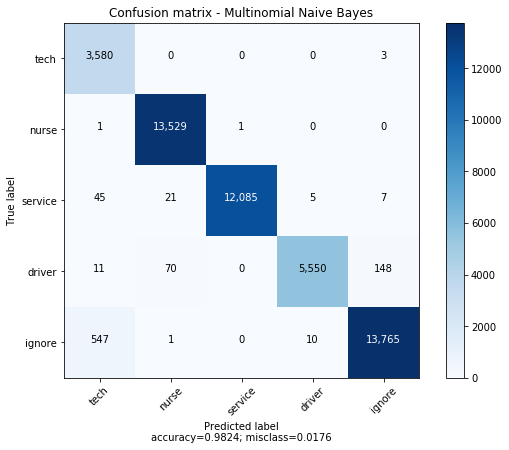

In [10]:
plot_confusion_matrix(mnb_cm, target_names=cm_labels, title='Confusion matrix - Multinomial Naive Bayes',
                      cmap=None, normalize=False)

In [123]:
print('MULTINOMIAL NAIVE BAYES')

print('\nOverall metrics')
print('accuracy = 0.982, precision = 0.984, recall = 0.982, f1 = 0.983')

print('\nIn class metrics')

class_metrics_df(mnb_cm, cm_labels)

MULTINOMIAL NAIVE BAYES

Overall metrics
accuracy = 0.982, precision = 0.984, recall = 0.982, f1 = 0.983

In class metrics


,precision,recall,f1 score,jaccard
tech,0.8556,0.9992,0.9218,0.8550
nurse,0.9932,0.9999,0.9965,0.9931
service,0.9999,0.9936,0.9967,0.9935
driver,0.9973,0.9604,0.9785,0.9579
ignore,0.9887,0.9610,0.9747,0.9506


<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

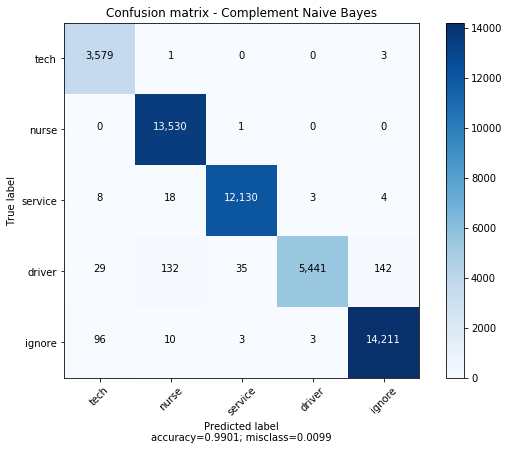

In [11]:
plot_confusion_matrix(cnb_cm, target_names=cm_labels, title='Confusion matrix - Complement Naive Bayes',
                      cmap=None, normalize=False)

In [124]:
print('COMPLEMENT NAIVE BAYES')

print('\nOverall metrics')
print('accuracy = 0.990, precision = 0.990, recall = 0.990, f1 = 0.990')

print('\nIn class metrics')
class_metrics_df(cnb_cm, cm_labels)

COMPLEMENT NAIVE BAYES

Overall metrics
accuracy = 0.990, precision = 0.990, recall = 0.990, f1 = 0.990

In class metrics


,precision,recall,f1 score,jaccard
tech,0.9642,0.9989,0.9812,0.9631
nurse,0.9882,0.9999,0.9940,0.9882
service,0.9968,0.9973,0.9970,0.9941
driver,0.9989,0.9415,0.9694,0.9405
ignore,0.9896,0.9922,0.9909,0.9820


## Update

Logistic regression performs best across all metrics. Both weighted, and for individual classes. Precision, Recall, F1 score and Jaccard Index

## Future work

+ Imbalanced metrics - F1 Score vs G-measure vs Jaccard index
+ add database connections to store data
+ train full naive bayes model for production
+ explore complement naive bayes
+ interface/webapp to confirm labels to add/correct data & retrain model
+ continue to explore more complex models
+ look into unsupervized methods & clustering
+ incorporate company name
+ add training examples for other types of roles 
+ software roles, consulting, accounting, etc.